# Trabajo práctico 1 - Simulación

In [ ]:
import sys
!{sys.executable} -m pip install scipy

import matplotlib.pyplot as plt
from collections import Counter
from random import random
import math
import scipy.stats as st
import numpy as np

## Ejercicio 1

**1- Utilizando Matlab, Octave o Python implementar un Generador Congruencial Lineal (GCL) de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera de la suma ponderada (0,15-0,25-0,6) de los números de padrón de los integrantes del grupo, ordenados ascendentemente.**
* **Informar los primeros 5 números de la secuencia.**
* **Modificar el GCL para que devuelva números al azar entre 0 y 1, y realizar un histograma sobre 100.000 valores generados.**

In [ ]:
def GCL(multiplier, seed, increment, module, generated_length):
    l = [(multiplier * seed + increment) % module]
    for i in range(1, generated_length):
        l.append( (multiplier * l[i-1] + increment) % module)
    return l

def plot_values(histogram_values, title, x_label, y_label, num_bins = 100):
    fig, ax = plt.subplots()

    n, bins, patches = ax.hist(histogram_values, num_bins, density=1)
    gcl_histogram = plt.hist(histogram_values, bins = num_bins)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.show()

In [ ]:
seed = int(99136 * 0.15 + 92308 * 0.25 + 97092 * 0.6)
five_numbers = GCL(1013904223, seed, 1664525, 232, 5)
five_numbers

In [ ]:
histogram_values = list(map(lambda x: x/232, GCL(1013904223, seed, 1664525, 232, 100000)))

In [ ]:
plot_values(histogram_values, 'GCL histogram plot', 'Values', 'Number of occurrences')

In [ ]:
counting_elements = Counter(histogram_values)
counting_elements

Como se puede observar, hay únicamente 4 valores diferentes que se repiten 25000 veces cada uno. El rango del GCL con esos valores es 4, mucho menor al módulo provisto.

## Ejercicio 2

**Utilizando el generador de números aleatorios con distribución uniforme [0,1] implementado en el ejercicio 1 y utilizando el método de la transformada inversa genere números pseudoaleatorios con distribución exponencial negativa de media 20.**
* **Realizar un histograma de 100.000 valores obtenidos.**
* **Calcular la media y varianza de la distribución obtenida y compararlos con los valores teóricos.**

In [ ]:
def inversa_exponencial(random_value, lambda_value = 1):
    return (-1/lambda_value) * math.log(1 - random_value)

lambda_value = 1/20

# This are the values generated with random input
#exponencial_values = [inversa_exponencial(random(), lambda_value) for _ in range(100000)]
histogram_values = list(map(lambda x: x/232, GCL(1013904223, seed, 1664525, 232, 100000)))
exponencial_values = list(map(lambda x: inversa_exponencial(x, lambda_value), histogram_values))

plot_values(exponencial_values, 'exponential histogram plot', 'Values', 'Number of occurrences')

In [ ]:
exponential_mean = np.mean(exponencial_values)
exponential_standard_deviation = np.std(exponencial_values)

In [ ]:
print("Esperanza: ", exponential_mean)
print("Varianza: ", exponential_standard_deviation ** 2)

Tal como era de esperar, los cuatro valores generados por la función de GCL se transforman en otros nuevos 4 valores. Tanto la forma del gráfico como los valores de la esperanza y la varianza (deberían ser 20 y 400 respectivamente) distan de lo esperado.

## Ejercicio 3

**Utilizando el método de Box-Muller genere de números aleatorios con distribución normal standard.**
* **Realizar un histograma de 100.000 valores obtenidos.**
* **Calcular la media y varianza de la distribución obtenida y compararlos con los valores teóricos.**

In [ ]:
def box_muller(u1, u2):
    z1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    z2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    return z1,z2


normal_values = []
for _ in range(50000):
    normal_values_tuple = box_muller(random(), random())
    normal_values.append(normal_values_tuple[0])
    normal_values.append(normal_values_tuple[1])
    

plot_values(normal_values, 'Normal (Box-Muller) histogram plot', 'Values', 'Number of occurrences')

In [ ]:
normal_mean = np.mean(normal_values)
normal_standard_deviation = np.std(normal_values)
print("Esperanza: ", normal_mean)
print("Varianza: ", normal_standard_deviation ** 2)

Los valores obtenidos son muy similares a los esperados

## Ejercicio 4

**Genere 100.000 número aleatorios condistribución Normal de media 40 y desvío estándar 6 utilizando el algoritmo de Aceptación y Rechazo.**
* Realizar un histograma de frecuencias relativas con todos los valores obtenidos.
* Comparar, en el mismo gráfico, el histograma realizado en el punto anterior con la distribución normal brindada por Matlab, Octave o Python.
* Calcular la media y la varianza de la distribución obtenida y compararlos con los valores teóricos.

## Ejercicio 5
Utilizando el método de la transformada inversa y utilizando el generador de números aleatorios implementado en el ejercicio 1 genere números aleatorios siguiendo la siguiente función de distribución de probabilidad empírica.
Probabilidad      Valor generado
     .4                 1
     .3                 2
     .12                3
     .1                 4
     .08                5
     
Muestre los resultados obtenidos en un histograma.

In [ ]:
def transform_values_to_discrete_distribution(u):
    if (u <= 0.4):
        return 1
    elif (u <= 0.7):
        return 2
    elif (u <= 0.82):
        return 3
    elif (u <= 0.92):
        return 4
    else:
        return 5

# This are the values generated with random input
#discrete_values = [transform_values_to_discrete_distribution(random()) for _ in range(100000)]

ej1_values = list(map(lambda x: x/232, GCL(1013904223, seed, 1664525, 232, 100000)))
discrete_values = list(map(lambda x: transform_values_to_discrete_distribution(x), ej1_values))

plot_values(discrete_values, 'Discrete histogram plot', 'Values', 'Number of occurrences', num_bins = 5)

## Ejercicio 6
Utilizando 2 generadores de números al azar, provistos por el lenguaje elegido para resolver el tp, con distribuciones uniformes en [-1,1] genere números aleatorios en un círculo de radio 1 centrado en el origen.
Muestre el resultado en un gráfico de 2 dimensiones.

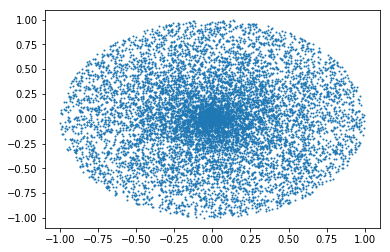

In [91]:
def circle_point():
    angle = random() * math.pi * 2
    distance_to_center = random()
    x = math.cos(angle) * distance_to_center
    y = math.sin(angle) * distance_to_center
    return (x, y)
    
x_points = []
y_points = []
for _ in range(10000):
    x, y = circle_point()
    x_points.append(x)
    y_points.append(y)

    
plt.scatter(x_points, y_points, s = 1)
plt.show()